### Before continuing, make sure you have Wiki DB installed and in the same directory as this program. See README for link

## Description of Data Set and CNN goal
The Convolutional Neural Network (CNN) built in this project aims to recognize and classify images of faces based on the provided metadata. <br>
Specifically, the CNN will be trained to:
Identify the Gender and Predict the Age of a person based on their face.

## Import Dependencies 

In [2]:
import scipy.io
import os
import matplotlib.pyplot as plt
from PIL import Image
from datetime import datetime, timedelta
import splitfolders
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout
from keras.models import Model
from keras.optimizers import Adam
from numba import cuda
import os



## Load Relevant Metadata

In [3]:
# Path to the local dataset directory
import numpy as np


data_dir = './wiki'

# Path to the metadata file
metadata_file = os.path.join(data_dir, 'wiki.mat')

# Load the metadata from the .mat file
metadata = scipy.io.loadmat(metadata_file)
# Extract the relevant metadata
wiki_data = metadata['wiki'][0, 0]
all_image_paths = wiki_data['full_path'][0]
print(all_image_paths)
names = wiki_data['name'][0]
genders = wiki_data['gender'][0]
birthdates = wiki_data['dob'][0]
photo_taken = wiki_data['photo_taken'][0]

# Calculate age
# Function to convert MATLAB serial date number to a readable date
def convert_dob(dob):
    reference_date = datetime(1, 1, 1)
    days_since_reference = int(dob)
    actual_date = reference_date + timedelta(days=days_since_reference - 366)
    return actual_date.strftime("%Y-%m-%d")  # Format as Year-Month-Day

# Calculate ages
ages = []
for dob, photo_year in zip(birthdates, photo_taken):
    birthdate = convert_dob(dob)
    age = photo_year - int(birthdate[:4])

    ages.append(age)

ages = np.array(ages)
# MATLAB's reference date (0 days since year 0)
reference_date = datetime(1, 1, 1)



[array(['17/10000217_1981-05-05_2009.jpg'], dtype='<U31')
 array(['48/10000548_1925-04-04_1964.jpg'], dtype='<U31')
 array(['12/100012_1948-07-03_2008.jpg'], dtype='<U29') ...
 array(['09/9998109_1972-12-27_2013.jpg'], dtype='<U30')
 array(['00/9999400_1981-12-13_2011.jpg'], dtype='<U30')
 array(['80/999980_1954-06-11_2008.jpg'], dtype='<U29')]


## Visualize 5 examples 

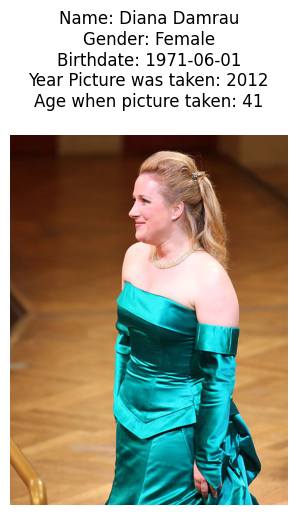

In [4]:

# Function to display an image with its metadata
def display_image_with_metadata(image_path, name, gender, dob, photo_taken, age):
    # Construct the full image path
    full_image_path = os.path.join(data_dir, image_path[0])
    birthdate_str = convert_dob(dob)

    # Open and display the image
    image = Image.open(full_image_path)
    plt.imshow(image)
    plt.imshow(image)
    title = (f"Name: {name[0]}\n"
            f"Gender: {'Male' if gender == 1 else 'Female' }\n"
             f"Birthdate: {birthdate_str}\n"
             f"Year Picture was taken: {photo_taken}\n"
             # Can be off by 1 year, since db does not have month/day picture was taken
             f"Age when picture taken: {age}\n"
             )
    plt.title(title)
    plt.axis('off')
    # plt.show()

# Display a few images with their metadata
for i in range(5):
    display_image_with_metadata(all_image_paths[i], names[i], genders[i], birthdates[i], photo_taken[i], ages[i])
    

## Split Data


In [5]:
# Split data between training and testing
# Check if the directory with split data already exists
if not os.path.exists("./wiki_split_data"):
    # Split data between training and testing
    splitfolders.ratio('./wiki', output="./wiki_split_data", seed=1337, ratio=(0.7, 0.15, 0.15))


## Prepare data for model

In [6]:
import os
import numpy as np
import scipy.io
from datetime import datetime, timedelta

# Function to get all image paths in a directory
def get_image_paths(directory):
    image_paths = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.jpg'):
                image_paths.append(os.path.join(root, file))
    return image_paths

# Function to extract labels based on image paths
def extract_labels(image_paths, metadata_dict):
    extracted_ages = []
    extracted_genders = []
    for path in image_paths:
        file_name = os.path.basename(path)
        if file_name in metadata_dict:
            metadata = metadata_dict[file_name]
            extracted_ages.append(metadata['age'])
            extracted_genders.append(metadata['gender'])
        else:
            print(f'No match found for: {path}')
    return np.array(extracted_ages), np.array(extracted_genders)


# Create a mapping from file paths to metadata
metadata_dict = {}
for path, age, gender in zip(all_image_paths, ages, genders):
    file_name = os.path.basename(path[0])
    metadata_dict[file_name] = {'age': age, 'gender': gender}

# Get image paths for train, validation, and test datasets
train_image_paths = get_image_paths('./wiki_split_data/train')
val_image_paths = get_image_paths('./wiki_split_data/val')
test_image_paths = get_image_paths('./wiki_split_data/test')

print("Train Image Paths:", train_image_paths[:5])  # Print first 5 paths for verification
print("Validation Image Paths:", val_image_paths[:5])  # Print first 5 paths for verification
print("Test Image Paths:", test_image_paths[:5])  # Print first 5 paths for verification

# Extract labels for train, validation, and test datasets
y_train_ages, y_train_genders = extract_labels(train_image_paths, metadata_dict)
y_val_ages, y_val_genders = extract_labels(val_image_paths, metadata_dict)
y_test_ages, y_test_genders = extract_labels(test_image_paths, metadata_dict)

# Print shapes to confirm
print(f'y_train_ages shape: {y_train_ages.shape}')
print(f'y_train_genders shape: {y_train_genders.shape}')
print(f'y_val_ages shape: {y_val_ages.shape}')
print(f'y_val_genders shape: {y_val_genders.shape}')
print(f'y_test_ages shape: {y_test_ages.shape}')
print(f'y_test_genders shape: {y_test_genders.shape}')


Train Image Paths: ['./wiki_split_data/train/61/2399661_1977-09-02_2008.jpg', './wiki_split_data/train/61/9494361_1962-04-21_1994.jpg', './wiki_split_data/train/61/44438061_1937-11-14_1969.jpg', './wiki_split_data/train/61/41899761_1989-10-06_2012.jpg', './wiki_split_data/train/61/37117161_1956-11-28_1986.jpg']
Validation Image Paths: ['./wiki_split_data/val/61/19242061_1982-08-16_2009.jpg', './wiki_split_data/val/61/8794261_1970-10-06_2011.jpg', './wiki_split_data/val/61/2483261_1981-02-19_2012.jpg', './wiki_split_data/val/61/4293661_1967-05-16_1995.jpg', './wiki_split_data/val/61/36075861_1983-09-23_2014.jpg']
Test Image Paths: ['./wiki_split_data/test/61/37699961_1890-12-11_1947.jpg', './wiki_split_data/test/61/2075561_1966-06-14_2010.jpg', './wiki_split_data/test/61/22156261_1992-10-16_2011.jpg', './wiki_split_data/test/61/328261_1946-08-06_2007.jpg', './wiki_split_data/test/61/382561_1961-10-09_2009.jpg']
y_train_ages shape: (43581,)
y_train_genders shape: (43581,)
y_val_ages shap

## Build model

In [20]:
# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
    tf.keras.layers.AveragePooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation="relu"),
    tf.keras.layers.GlobalMaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=2, activation="softmax")  # 2 classes for gender classification
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(), loss="binary_crossentropy", metrics=["accuracy"])


## Convert Images to Arrays to Feed the Model

In [12]:
import concurrent.futures

# Preprocess a single image
def preprocess_image(path):
    try:
        img = tf.keras.preprocessing.image.load_img(path, target_size=(128, 128))
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = np.array(img) / 255.0  # Normalize to [0, 1]
        return img
    except Exception as e:
        print(f"Error loading image {path}: {e}")
        return None

# Preprocess images using parallel processing
def preprocess_images(image_paths):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        images = list(executor.map(preprocess_image, image_paths))
    # Filter out any None values in case of errors
    images = [img for img in images if img is not None]
    return np.array(images)

# Limit to 5000 images
train_image_paths_limited = train_image_paths[:5000]
val_image_paths_limited = val_image_paths[:5000]
test_image_paths_limited = test_image_paths[:5000]

# Preprocess the images
x_train = preprocess_images(train_image_paths_limited)
x_val = preprocess_images(val_image_paths_limited)
x_test = preprocess_images(test_image_paths_limited)

# Limit the target labels to 5000 elements
y_train_limited = y_train_genders[:5000]
y_val_limited = y_val_genders[:5000]
y_test_limited = y_test_genders[:5000]

# Convert labels to categorical for binary classification
y_train_limited = tf.keras.utils.to_categorical(y_train_limited, num_classes=2)
y_val_limited = tf.keras.utils.to_categorical(y_val_limited, num_classes=2)
y_test_limited = tf.keras.utils.to_categorical(y_test_limited, num_classes=2)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/utils/numerical_utils.py:86: RuntimeWarning: invalid value encountered in cast
  x = np.array(x, dtype="int64")


## Train the Model

In [21]:

# Train the model with the smaller subset
history = model.fit(x_train, y_train_limited, epochs=10, batch_size=16, validation_data=(x_val, y_val_limited))


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7603 - loss: 0.5626

## Model Evaluation

157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step


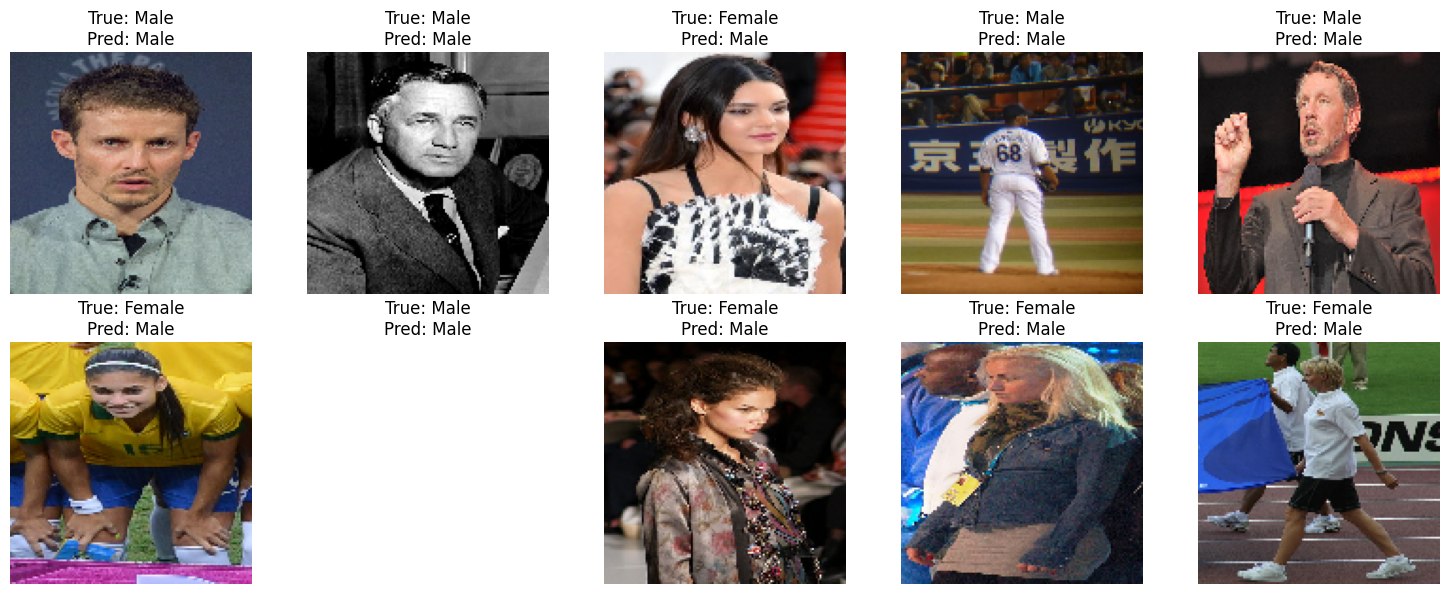

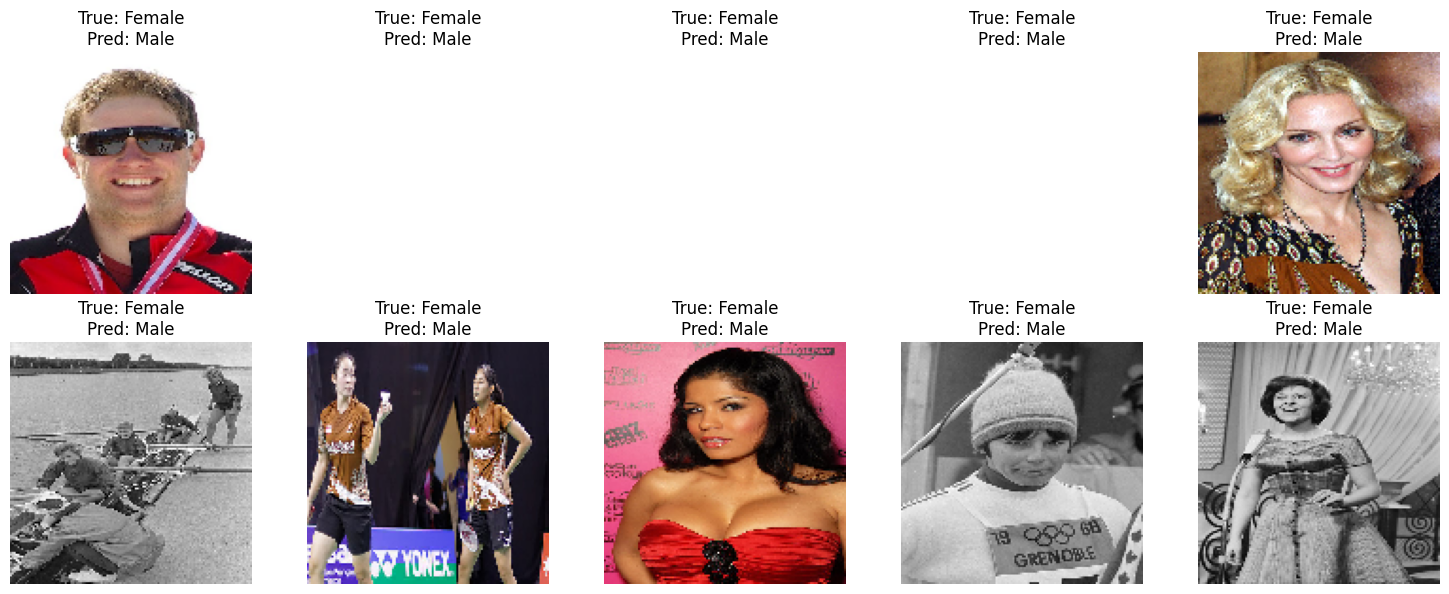

Accuracy: 0.76


In [19]:
from sklearn.metrics import confusion_matrix

def gender_prediction(number):
    return "Male" if number == 1 else "Female"

def convert_to_gender_labels(y):
    return np.array([gender_prediction(label) for label in np.argmax(y, axis=1)])

def display_images_with_predictions(x_test, y_true_gender, y_pred_gender, num_images=10):
    # Randomly select some images
    indices = np.random.choice(range(len(x_test)), num_images, replace=False)

    # Set up the plot
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()

    for i, idx in enumerate(indices):
        # Display the image
        if x_test.shape[-1] == 1:  # Grayscale images
            axes[i].imshow(x_test[idx].squeeze(), cmap='gray')
        else:  # Color images
            axes[i].imshow(x_test[idx])
        
        # Set the title with true and predicted labels
        axes[i].set_title(f"True: {y_true_gender[idx]}\nPred: {y_pred_gender[idx]}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

def display_misclassified_images(x_test, y_true_gender, y_pred_gender, num_images=10):
    # Find misclassified samples
    misclassified = np.where(y_pred_gender != y_true_gender)[0]
    
    # Randomly select from misclassified if there are more than num_images
    if len(misclassified) > num_images:
        indices = np.random.choice(misclassified, num_images, replace=False)
    else:
        indices = misclassified

    # Set up the plot
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()

    for i, idx in enumerate(indices):
        if x_test.shape[-1] == 1:  # Grayscale images
            axes[i].imshow(x_test[idx].squeeze(), cmap='gray')
        else:  # Color images
            axes[i].imshow(x_test[idx])
        
        axes[i].set_title(f"True: {y_true_gender[idx]}\nPred: {y_pred_gender[idx]}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Main execution
# Make predictions on the test dataset
y_pred = model.predict(x_test)

y_true_gender = convert_to_gender_labels(y_test_limited)
y_pred_gender = convert_to_gender_labels(y_pred)

# Display random images
display_images_with_predictions(x_test, y_true_gender, y_pred_gender)

# Display misclassified images
display_misclassified_images(x_test, y_true_gender, y_pred_gender)

# Calculate and print accuracy
accuracy = np.mean(y_pred_gender == y_true_gender)
print(f"Accuracy: {accuracy:.2f}")




## Analysis of findings
